In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import scipy as sc
from scipy import signal
import matplotlib.pyplot as plt
from numpy import matlib as mb
import multiprocessing
from tqdm.notebook import tqdm as tqdm
from functools import partial
from scipy.ndimage import gaussian_filter

## MATLAB code used by Dr. Eric Oliver


## PYTHON code for WK99 spectra

In [2]:
example_data = xr.open_dataset('/home/cccr/roxy/panini/JGRJD_MJO_CMIP_III/MJO_tracking/TRMM_3B42/grid_1/trmm_anom_daily_1998-2019_rg_new.nc')
# example_data = xr.open_dataset('/home/cccr/roxy/panini/test1.nc')
data         = example_data['pr'].sel(lat=slice(-15,15)).values

In [3]:
data.shape

(7700, 360, 30)

In [5]:
def fft2d(seg,var_seg):
    '''
    calculates power using 2D-FFT
    var_seg : precip /olr dim:time x lon x seg_no
    seg     : seg_no
    p0      : power (time x lon x seg_no )
    '''
    p0 = np.abs(np.fft.fftshift(np.roll(sc.fft.fft2(var_seg[:,:,seg].T),-1,axis=1)))
    return p0

def spectra_seg(var_eq,T,X,nseg,taperwin):
    '''
    Split into segments  of length 96 (over-lapping)
    var_eq : precip/olr at particular latitude dim : tim x lon
    T      : length of segments from which to generate independent spectra
             (e.g., 96 in the WK99 paper). The final spectra are then generated
             by averaging over all the segments.
    X      : dim of lon (360)
    nseg   : No of segment
    taperwin: tapering window with len T
    var_seg : overlapping segment dim : (T x lon x 2*no_seg )
    p_seg   : power for each seg  dim : (T x lon x 2*no_seg )
    '''
    var_seg            = np.zeros((T,X,2*nseg))
    
    for i in range(X):
        var_seg_tmp    = np.reshape(var_eq[:int(nseg*T),i] , (nseg , T)).T;                                      # % 96 day segments
        var_seg_tmp    = np.hstack([var_seg_tmp, np.reshape(var_eq[int(T/2)+np.arange(nseg*T),i],(nseg,T )).T]); # % overlapping segments (96/2 day overlap)
        var_seg_tmp    = signal.detrend(var_seg_tmp,0)*taperwin;                                                 # % taper t.s.
        var_seg[:,i,:] = var_seg_tmp*1.0
    
    ## 2D-FFT
    
    p_seg              = np.zeros((X,T));                                                           #%length(floor(T/2)+2:T),X);
    fft2d_x            = partial(fft2d, var_seg=var_seg)
    
    pool               = multiprocessing.Pool(processes=8)
    r                  = pool.map(fft2d_x, np.arange(var_seg.shape[2]))
    pool.close()
    pool.join()
    
    for i in r:
        p_seg = p_seg + np.fliplr(i);
        
    return var_seg,p_seg

def wk99(data,T):
    '''
         # %  Written By : Eric Oliver . original code was in MATLAB.
        # %  [f,k,p_S,p_A,p_T,p_bg] = wk99(data,T)
        # %  
        # %  Frequency-wavenumber diagram as described in Wheeler and Kiladis (1999).
        # %  Note that this script DOES NOT calculate the background spectrum and
        # %  calculate the ratio of the symmetric and anti-symmetric parts to the
        # %  background. This can be done using code something like:
        # %   > sum(p_S,3) ./ two_dim_smoothing(sum(p_S,3))
        # %  to give a symmetric spectrum "anomaly" as presented in WK99
        # %
        # %  The input quantities are as follows:
        # %
        # %   data - data from which to generate the WK99 diagram. Should have
        # %          dimensions of [ time x longitude x latitude ]. The latitudes
        # %          must be symmetric about the equator
        # %   T    - length of segments from which to generate independent spectra
        # %          (e.g., 96 in the WK99 paper). The final spectra are then generated
        # %          by averaging over all the segments.
        # %
        # %  The output quantities are as follows:
        # %  
        # %   f    - frequencies [ rad / "sample rate" ]
        # %   k    - wavenumbers [ rad / "sample rate" ]
        # %   p_S  - 2D spectral density of symmetric variability
        # %   p_A  - 2D spectral density of anti-symmetric variability
        # %   p_T  - 2D spectral density of total variability
        # %  
    '''
    #     % some sizes
    X = data.shape[1]; Y = data.shape[2];

    #     % sumber of segments to average over
    nseg = int(np.floor(np.size(data,0)/T))
    if ((nseg*T)+T/2 > np.size(data,0)):
        nseg = nseg-1

    #     % generate tapering window
    taperwin = signal.tukey(T,0.25)[:,np.newaxis]*np.ones((T,2*nseg))
    
 
    #     % allocate matrices
    p_T = np.zeros((X,T,Y)); p_S = np.zeros((X,T,Y)); p_A = np.zeros((X,T,Y))

    data[np.isnan(data)]=0.0
    for j in tqdm(range(Y)):
        var_eq   = data[:,:,j]                                                                  #% % var at lat
        var_eq2  = data[:,:,Y-j-1];                                                                #% var at -lat
        var_eq_S = 0.5*( var_eq + var_eq2 );                                                    #% symmetric component
        var_eq_A = 0.5*( var_eq - var_eq2 );                                                    #% anti-symmetric component
        var_eq_S = signal.detrend(var_eq_S,0); var_eq_A = signal.detrend(var_eq_A,0);           #% detrend temporally
        var_eq_S = signal.detrend(var_eq_S.T,0).T; var_eq_A = signal.detrend(var_eq_A.T,0).T;   #% detrend spatially
        # % -----
         # % TOTAL
         # % segments
        var_seg,p_seg     = spectra_seg(var_eq,T,X,nseg,taperwin)
        p_T[:,:,j]        = p_seg/var_seg.shape[2];
        
        # % ---------
        # % SYMMETRIC
        # % segments
        var_seg,p_seg     = spectra_seg(var_eq_S,T,X,nseg,taperwin)
        p_S[:,:,j]        = p_seg/var_seg.shape[2];
           # % ---------
        # % ANTI-SYMMETRIC
        # % segments
        var_seg,p_seg     = spectra_seg(var_eq_A,T,X,nseg,taperwin)
        p_A[:,:,j]        = p_seg/var_seg.shape[2];

    f = 2*np.pi*np.arange(T)/T; f[np.where(f>=np.pi)] = f[np.where(f>=np.pi)]-2*np.pi; f = np.fft.fftshift(f); 
    k = 2*np.pi*np.arange(X)/X; k[np.where(k>=np.pi)] = k[np.where(k>=np.pi)]-2*np.pi; k = np.fft.fftshift(k); 
    
    #     k1 = 360/(2*np.pi/(k));
    #     f1  = 2*np.pi/f; 
    #     f1[np.isinf(f1)]=np.nan; 
    
    return p_T,p_S,p_A,f,k


In [6]:
%%time
p_T,p_S,p_A,f,k = wk99(data,T=96) 


CPU times: user 36min 20s, sys: 5min 28s, total: 41min 48s
Wall time: 6min 35s


In [7]:
Y = data.shape[2]
lat = example_data['pr'].sel(lat=slice(-15,15)).lat.values
j=17
lat[j],lat[Y-j-1]

(2.5, -2.5)

## freq to time period and  K to wavenumber

In [11]:
f1  = 2*np.pi/f; 
k1  = 360/(2*np.pi/k)
f1[np.isinf(f1)]=np.nan; 
# k1[np.isinf(k1)]=0;
f1,k1,f

/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


(array([ -2.        ,  -2.04255319,  -2.08695652,  -2.13333333,
         -2.18181818,  -2.23255814,  -2.28571429,  -2.34146341,
         -2.4       ,  -2.46153846,  -2.52631579,  -2.59459459,
         -2.66666667,  -2.74285714,  -2.82352941,  -2.90909091,
         -3.        ,  -3.09677419,  -3.2       ,  -3.31034483,
         -3.42857143,  -3.55555556,  -3.69230769,  -3.84      ,
         -4.        ,  -4.17391304,  -4.36363636,  -4.57142857,
         -4.8       ,  -5.05263158,  -5.33333333,  -5.64705882,
         -6.        ,  -6.4       ,  -6.85714286,  -7.38461538,
         -8.        ,  -8.72727273,  -9.6       , -10.66666667,
        -12.        , -13.71428571, -16.        , -19.2       ,
        -24.        , -32.        , -48.        , -96.        ,
                 nan,  96.        ,  48.        ,  32.        ,
         24.        ,  19.2       ,  16.        ,  13.71428571,
         12.        ,  10.66666667,   9.6       ,   8.72727273,
          8.        ,   7.38461538,   6.

## Solve dispersion relation from WK99 and 2009


## $\frac{\sqrt{gh_e}}{\beta}(\frac{\omega^2}{gh_e}-k^2-\frac{k}{\omega}\beta)=2n+1  $
## $ n=-1,0,1,2,3,4. \;\;\; h_e = 12,25,50,90m. \;\;\; \beta = 2.28x10^-11 s^-1 \;\;\; g=9.8 ms^-1 $


In [29]:
import sympy 
from sympy import symbols, exp, sqrt, solve
from sympy import lambdify
import numpy 
import cmath
import matplotlib.pyplot as plt
g,he,beta,omega,K,n=symbols('g,h_e,beta,omega,K,n')


def funct(g,he,beta,K,n,omega):
    return (sqrt(g*he)/beta)*(1/(g*he)*omega**2-K**2-(K/omega)*beta)-(2*n+1)

def three_roots(f,k):
    
    he = [15,25,50,90]
    n  = np.arange(-1,5,1)
    g1         =   9.8
    beta1      =   2.28*10**(-11)
    c1         =   (9.8*he1)**0.500                       
    req    =   (c1/beta1)**0.500
    factor2    =   (c1*beta1)**0.500
    
    
    f1  = 2*np.pi/f; 
    k1  = 360/(2*np.pi/k)
    f1[np.isinf(f1)]=np.nan;

    root1 = np.zeros((len(k1[np.abs(k1)<11]),len(n),len(he)))
    root2 = np.zeros((len(k1[np.abs(k1)<11]),len(n),len(he)))
    root3 = np.zeros((len(k1[np.abs(k1)<11]),len(n),len(he)))


    for i in tqdm(range(len(he))):
        nn=0;
        for j in tqdm(range(len(n))):
            x1=[]
            x2=[]
            x3=[]

            for kk in k:
                ff1=funct(g1,he[i],beta1,kk/110000,n[j],omega)
                ans=solve(ff1,omega)
                z1=complex(ans[-1])
                z2=complex(ans[1])
                z3=complex(ans[0])   
                x1.append(z1.real*86400)
                x2.append(z2.real*86400)
                x3.append(z3.real*86400)

            xx1 = np.array(x1)[np.abs(k1)<11]
            xx2 = np.array(x2)[np.abs(k1)<11]
            xx3 = np.array(x3)[np.abs(k1)<11]
            kk1 = k1[np.abs(k1)<11]

            xx2[kk1==0] = np.nan
            xx3[kk1==0] = np.nan

            root1[:,j,i] = xx1/(2*np.pi)
            root2[:,j,i] = xx2/(2*np.pi)
            root3[:,j,i] = xx3/(2*np.pi)
           
    return root1,root2,root3

def draw_spectra(p_T,f,k,root1,root2,root3):
    f1  = 2*np.pi/f; 
    k1  = 360/(2*np.pi/k)
    f1[np.isinf(f1)]=np.nan
    ## plot the observed Spectra
    aa = np.nanmean(p_T,2).T
    aa1 = gaussian_filter(aa, sigma=10)
    fig,ax =plt.subplots(1,1,figsize=(10,10))
    m1=ax.contourf(k1,1/f1,aa/aa1,cmap='Spectral_r',levels=np.arange(1.0,2.1,.1),extend='both')
    ax.set_ylim([1/f1[f1==96],0.8])
    ax.set_xlim(-12,12)
    plt.colorbar(m1)
    plt.xlabel('Wave-number')
    plt.ylabel('frequency')
    plt.axhline(f[f1==96]/(2*np.pi),linestyle='--',color='k')
    plt.axhline(f[f1==19.2]/(2*np.pi),linestyle='--',color='k')
    plt.grid(color='k')
    
    ## plot the theoratical spectra
    for i in range(0,4):
        if i==0:
            ax.plot(kk1,root3[:,i,:-1],'-ok')
        elif i>2:
            ax.plot(kk1,root1[:,i,:-1],'-ok')
            ax.plot(kk1,root2[:,i,:-1],'-ok')


In [24]:
root1,root2,root3 = three_roots(f,k)

/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide
/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide


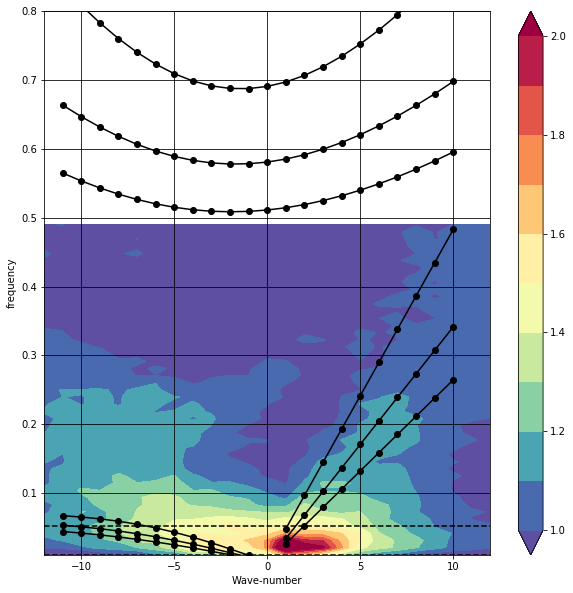

In [30]:
draw_spectra(p_T,f,k,root1,root2,root3)

## E/W ratio from average power

In [31]:
k1[np.where((k1>=1)&(k1<6))[0]],np.where((f1>20)&(f1<100))[0]
# p_T[k1[np.where((k1>=0)&(k1<6))[0]],np.where((f1>20)&(f1<100))[0]]
p_TT = np.nanmean(p_T,2)
xxe  = np.where((k1>=1)&(k1<6))[0];xxw = np.where((k1<=-1)&(k1>-6))[0]
yy   = np.where((f1>20)&(f1<100))[0]
ep   = np.mean(p_TT[xxe[0]:xxe[-1]+1,yy[0]:yy[-1]+1])
wp   = np.mean(p_TT[xxw[0]:xxw[-1]+1,yy[0]:yy[-1]+1])
ep**2/wp**2,k1[xxw],f1[yy]

/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


(1.4572492722426056,
 array([-6., -5., -4., -3., -2., -1.]),
 array([96., 48., 32., 24.]))

In [32]:
k1[np.where((k1>=1)&(k1<6))[0]],np.where((f1>20)&(f1<100))[0]
# p_T[k1[np.where((k1>=0)&(k1<6))[0]],np.where((f1>20)&(f1<100))[0]]
p_TT = np.nanmean(p_T,2)
aa1 = p_TT/gaussian_filter(p_TT, sigma=5)

xxe  = np.where((k1>=1)&(k1<6))[0];xxw = np.where((k1<=-1)&(k1>-6))[0]
yy   = np.where((f1>20)&(f1<100))[0]
ep   = np.mean(aa1[xxe[0]:xxe[-1]+1,yy[0]:yy[-1]+1])
wp   = np.mean(aa1[xxw[0]:xxw[-1]+1,yy[0]:yy[-1]+1])
ep**2/wp**2,k1[xxw],f1[yy]


/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


(1.4347028368808827,
 array([-6., -5., -4., -3., -2., -1.]),
 array([96., 48., 32., 24.]))

## Average E/W ratio from all segments 

In [33]:
ewratio_lat  = np.zeros(30)
for i in range(p_T.shape[2]):
    p_TT = p_T[:,:,i]
    xxe  = np.where((k1>=1)&(k1<6))[0];xxw = np.where((k1<=-1)&(k1>-6))[0]
    yy   = np.where((f1>20)&(f1<100))[0]
    ep   = np.mean(p_TT[xxe[0]:xxe[-1]+1,yy[0]:yy[-1]+1])
    wp   = np.mean(p_TT[xxw[0]:xxw[-1]+1,yy[0]:yy[-1]+1])
    ewratio_lat[i]= ep**2/wp**2
print("E/W ratio is %f"%np.mean(ewratio_lat))

E/W ratio is 1.473527


/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/cccr/roxy/panini/anaconda3/envs/saranya/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
